# Spatial-DC: a robust deep learning-based method for deconvolution of spatial proteomics
This analysis workflow demostreates the workflow for deconvolution of mass spectrometry (MS)-based spatial proteomics data by Spatial-DC.

[![python >3.9.20](https://img.shields.io/badge/python-3.9.20-brightgreen)](https://www.python.org/)

## Here is a demo code on python envirment to the deconvolution of Mouse Brain data by Spatial-DC.

In [1]:
# Load necessary packages
import os
import sys
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr,spearmanr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mat
from scipy import stats
# import cell2location
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import warnings
warnings.filterwarnings("ignore")

print(sys.version)
# plt.rcParams['font.size'] = 10
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42

3.9.20 | packaged by conda-forge | (main, Sep 30 2024, 17:49:10) 
[GCC 13.3.0]


In [2]:
# set the working directory
os.chdir("Spatial_DC/")
dataset_dir = "datasets/mouse_brain_coronal"
scaler = MinMaxScaler(feature_range=(0, 1))

## Overview of reference data and spatial proteomics data.

In [3]:
# Overview the reference proteomics data
sc_adata = sc.read_h5ad(f"{dataset_dir}/intersected_reference_proteomics.h5ad")

print(f"Protein intensity: {sc_adata.to_df().iloc[0:4,0:4]}\n")
print(f"The number of cells: {sc_adata.obs['celltype'].value_counts()}\n")
print("The total cells and intersected proteins:", sc_adata.shape)

Protein intensity: pid                 A2A432        A2A5R2       A2A690       A2A699
SampleID                                                          
Astrocytes_1  2.751401e+09  7.902602e+08  494508480.0  101820032.0
Astrocytes_2  2.290001e+09  4.647003e+08  412129472.0  266690128.0
Astrocytes_3  2.386300e+09  2.424399e+08  142812992.0  116619944.0
Microglia_1   3.382201e+09  1.366199e+09  646435264.0  194589952.0

The number of cells: celltype
Astrocytes          3
Microglia           3
Neurons             3
Oligodendrocytes    3
Name: count, dtype: int64

The total cells and intersected proteins: (12, 4351)


In [4]:
ct_order = ["Astrocytes","Neurons","Oligodendrocytes","Microglia"]

In [5]:
# Overview the spatial proteomics data
sp_adata = sc.read_h5ad(f"{dataset_dir}/intersected_spatial_proteomics.h5ad")
print(f"Protein intensity: {sp_adata.to_df().iloc[0:4,0:4]}\n")
print("The total spots and intersected proteins:", sp_adata.shape)

Protein intensity: pid           A2A432       A2A5R2      A2A690      A2A699
SampleID                                                 
A1        31987724.0  120250600.0  91481920.0  66077048.0
A2        36707364.0  159410656.0  99880256.0  48890692.0
A3        31565436.0  127586872.0  76132584.0  53496432.0
A4        35240712.0  130920272.0  77206704.0  56545344.0

The total spots and intersected proteins: (208, 4351)


In [6]:
# Load Intersection of reference and spatial datasets
intersect = np.intersect1d(sc_adata.var_names, sp_adata.var_names)        
sp_adata = sp_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()

sc.pp.normalize_total(sc_adata)
sc.pp.normalize_total(sp_adata)

print(sc_adata.shape)
print(sp_adata.shape)

(12, 4351)
(208, 4351)


## Create deconvolution model and load trained DIS model

In [7]:
# Load Spatial-DC package
from Spatial_DC import SpatialDC

# conda install pytorch-cluster -c pyg

# Load trained DIS model
model_path = f"trained_model/mouse_brain_coronal/model_epoch200.pt"

spatial_dc = SpatialDC(sc_adata=sc_adata, sp_adata=sp_adata, reference_data_type="single_cell_type", dataset_type="real") 
spatial_dc.load_distribution_model(load_model_path = model_path)
pred_sp_adata = spatial_dc.transfer_distribution_model()

In [8]:
pred_sp_adata.uns["cellperc_initial"].iloc[0:4,0:4] # Overview of the intermediate cell percentages

,Astrocytes,Microglia,Neurons,Oligodendrocytes
A1,0.302902,0.0,0.392742,0.304356
A2,0.340123,0.0,0.350986,0.308890
A3,0.324545,0.0,0.376317,0.299138
A4,0.339241,0.0,0.357817,0.302941


In [9]:
# Traine the self-supvervised model
spatial_dc.setup_self_supervised_model(k_graph=30, epochs=200)
spatial_dc.train_self_supervised_model()
spatial_dc.inference_self_supervised_model()

Training: 100%|██████████| 200/200 [00:53<00:00,  3.77epoch/s, loss=2.87585]


AnnData object with n_obs × n_vars = 208 × 4351
    obs: 'X', 'Y'
    var: 'gene', 'genes'
    uns: 'cellperc_initial', 'protein_weight_pred', 'cellperc_refined', 'protein_weight_reconstruct'
    obsm: 'spatial'

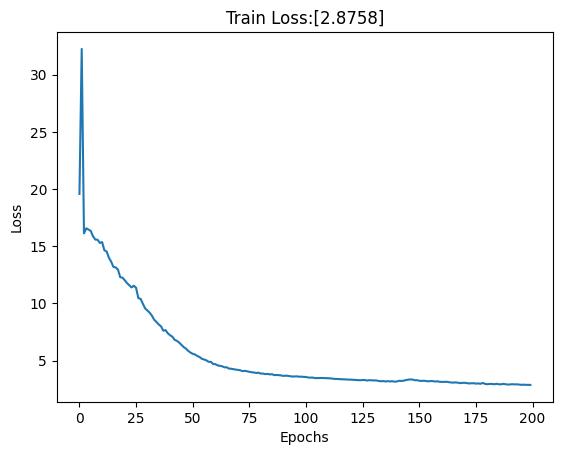

In [10]:
# print the train loss of SSM model
train_loss = spatial_dc.reconstruction_model.state["train_loss"]
epochs = spatial_dc.reconstruction_model.state["epochs"]
        
plt.plot(np.arange(0,epochs), train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Train Loss:[{"%.4f" % train_loss[-1]}]')
plt.show()
plt.close()   

In [11]:
# print the refined cell-type composition
pred_ct = pred_sp_adata[sp_adata.obs.index].uns["cellperc_refined"]
print("Here is the predicted cell-type composition:")
print(pred_ct.iloc[0:10,0:4])

Here is the predicted cell-type composition:
    Astrocytes  Microglia   Neurons  Oligodendrocytes
A1    0.289744        0.0  0.380625          0.329631
A2    0.295233        0.0  0.371206          0.333561
A3    0.298770        0.0  0.366011          0.335219
A4    0.303900        0.0  0.359445          0.336656
A5    0.300456        0.0  0.362958          0.336585
A6    0.292384        0.0  0.377046          0.330570
B1    0.289749        0.0  0.378756          0.331495
B2    0.286035        0.0  0.384293          0.329672
B3    0.290448        0.0  0.375785          0.333766
B4    0.304671        0.0  0.353433          0.341895


Here is the predicted cell-type composition


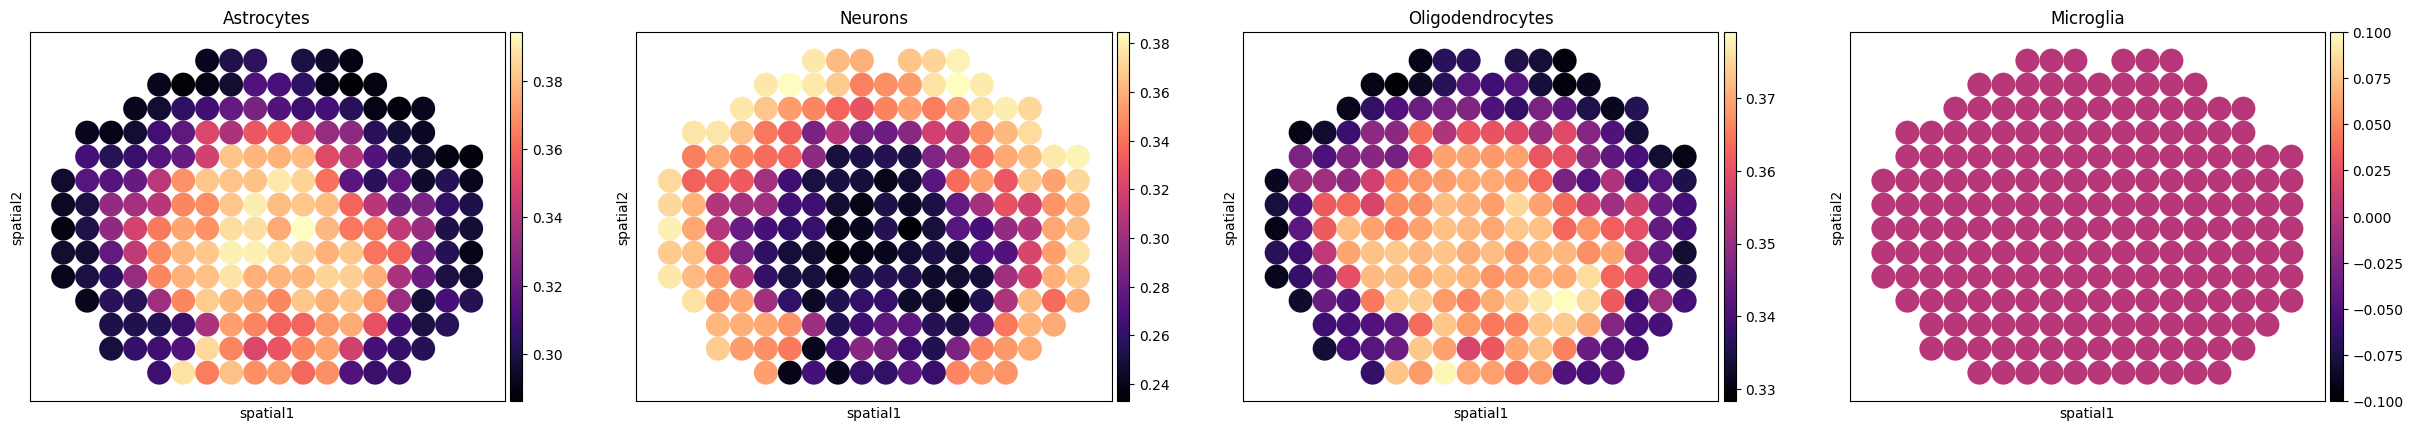

In [12]:
# Plot the distribution of predicted cell-type composition
sp_adata.obs = pred_ct[ct_order]
print("Here is the predicted cell-type composition")
sc.pl.spatial(sp_adata,spot_size=1,color=ct_order,color_map="magma",ncols=5,wspace=0.15)

## Assessment of reconstructing cell-type proteomic profiles by Spatial-DC

Protein intensity: pid                      A2A432       A2A5R2       A2A690      A2A699
ID                                                                   
A1_Astrocytes        45535540.0  120253160.0  181832000.0  79596648.0
A1_Neurons           27348574.0   64264420.0  137313168.0  62760764.0
A1_Oligodendrocytes  39722112.0  238600640.0          0.0  87533320.0
A2_Astrocytes        45390620.0  139945840.0  170663440.0  50996280.0

The total spots and intersected proteins: (624, 4351)
The number of cells: celltype
Astrocytes          208
Neurons             208
Oligodendrocytes    208
Name: count, dtype: int64

The total cells and intersected proteins: (624, 4351)


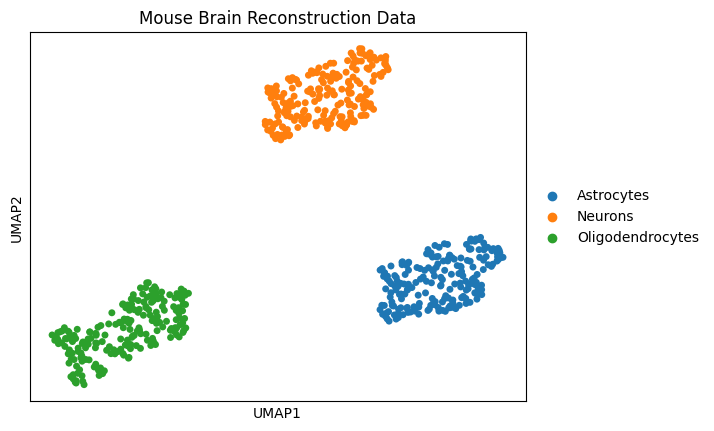

In [13]:
# Obtain the reconstructed adata from trained SSM
rec_scp_adata = spatial_dc.reconstruction(norm=True)

# UMAP of reconstructed adata
rec_scp_adata = rec_scp_adata[rec_scp_adata.obs["cellperc"] > 0,:]

print(f"Protein intensity: {rec_scp_adata.to_df().iloc[0:4,0:4]}\n")
print("The total spots and intersected proteins:", rec_scp_adata.shape)

print(f"The number of cells: {rec_scp_adata.obs['celltype'].value_counts()}\n")
print("The total cells and intersected proteins:", rec_scp_adata.shape)

sc.pp.normalize_total(rec_scp_adata)
sc.pp.log1p(rec_scp_adata)
sc.pp.scale(rec_scp_adata)
sc.pp.pca(rec_scp_adata)
sc.pp.neighbors(rec_scp_adata, n_pcs=20, n_neighbors=10)
sc.tl.umap(rec_scp_adata)
sc.pl.umap(rec_scp_adata, color=["celltype"], size=100, title="Mouse Brain Reconstruction Data")